## Problem 1.

In [168]:
import numpy as np
import cvxpy

In [169]:
from numpy.random import randn
n = 20 # dimension of x's
M = 25 # number of non-censored data points
K = 100 # total number of points

np.random.seed(1)
c_true = randn(n)
X = randn(n, K)
y = np.dot(X.T, c_true) + 0.1 * np.sqrt(n) * randn(K)
print(c_true.shape)

# Reorder measurements,then censor
sort_ind = np.argsort(y)
X = X[:, sort_ind];
y = y[sort_ind[:M + 1]]
D = (y[M - 1] + y[M]) / 2
y = y[:M]

def relative_error(c_t, c):
    return np.linalg.norm(c_t  - c) / np.linalg.norm(c_t)

(20,)


<b> Optimization problem :</b>

$$minimize \sum_{k=1}^{K} \left( y^{(k)}-c^T x^{(k)} \right)^2$$
$$ s.t. \qquad y^{(k)} = y_{k} \qquad \text{if} \quad k \leq M$$
$$\quad \qquad y^{(k)} \geq d_k \qquad \text{if} \quad M< k \leq K$$

In [170]:
Y = cvxpy.Variable(K)
C = cvxpy.Variable(n)

constraints = [Y[:M] == y,
               Y[M:] >= D]

objective = cvxpy.Minimize(cvxpy.norm(Y.T - C.T * X,  2) ** 2)

prob = cvxpy.Problem(objective, constraints)
prob.solve()

print ("status of solution:", prob.status)
print('Optimal value is: {0}'.format(prob.value))
#print('c = {0}'.format(C.value))
print('Error : {0}'.format(relative_error(c_true, C.value.T)))

status of solution: optimal
Optimal value is: 1.8860333180476694
Error : 0.08903535527924479


<b> Optimization problem :</b>

$$minimize \sum_{k=1}^{K} \left( y_k-c^T x^{(k)} \right)^2 \qquad k=1, \dots, M$$

In [171]:
C = cvxpy.Variable(n)

objective = cvxpy.Minimize(cvxpy.norm((y - (C.T * X[:, :M]).T),  2) ** 2)

prob = cvxpy.Problem(objective, [])
prob.solve()

print ("status of solution:", prob.status)
print('Optimal value is: {0}'.format(prob.value))
#print('c = {0}'.format(C.value))

print('Error is {0}'.format(relative_error(c_true, C.value.T)))

status of solution: optimal
Optimal value is: 0.9040511364289
Error is 0.2270967016778535


## Problem 2.

In [172]:
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

mat_contents = sio.loadmat('veh_sched_data.mat')

a = mat_contents['a'][0,0]
b = mat_contents['b'][0,0]
c = mat_contents['c'][0,0]
d = mat_contents['d'].squeeze()
n = mat_contents['n'][0,0]
smin = mat_contents['smin'].squeeze()
smax = mat_contents['smax'].squeeze()
tau_min = mat_contents['tau_min'].squeeze()
tau_max = mat_contents['tau_max'].squeeze()

In [173]:
T = cvxpy.Variable(n)

objective = a * d[0] ** 2 * cvxpy.inv_pos(T[0]) + b * d[0] + c * T[0]

constraints = []

for i in range(1, n):
    time_i = T[i] - T[i - 1]
    objective += a * d[i] ** 2 * cvxpy.inv_pos(time_i) + b * d[i] + c * time_i

    constraints.append(smin[i] * time_i <= d[i])
    constraints.append(smax[i] * time_i >= d[i])

for i in range(n):
    constraints.append(T[i] <= tau_max[i])
    constraints.append(T[i] >= tau_min[i])
    
prob = cvxpy.Problem(cvxpy.Minimize(objective), constraints)
prob.solve()

print ("status of solution:", prob.status)
print('Optimal value is: {0}'.format(prob.value))

times = np.array(T.value)[:, 0]
speeds = [d[0] / times[0]]

for i in range(1, n):
    speeds.append(d[i] / (times[i] - times[i - 1]))

status of solution: optimal
Optimal value is: 2617.825193522419


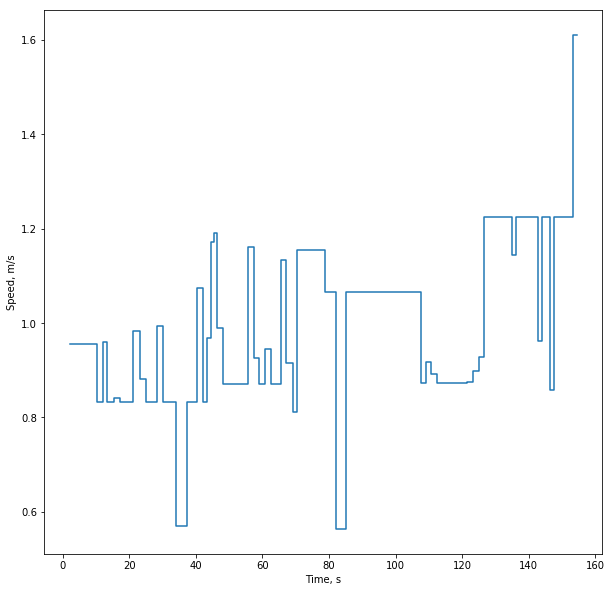

In [174]:
plt.figure(figsize=(10, 10))
plt.step(times, speeds)
plt.xlabel('Time, s')
plt.ylabel('Speed, m/s')

Pros and Cons:

* Dynamic programming allows us to define the step. It gives us the opportunity to affect the time of optimization.

* Convex optimization gives more exact solution but does it in larger time.



## Problem 7.

<b>Optimization problem:</b>
$$\displaystyle \min_{x_1,x_2 \in \mathbb{R}} \quad 2x_1^2+2x_2^2 -x_1x_2 $$
$$\text{subject to} \quad  2x_1+3x_2\geq1$$
$$\qquad \qquad 5x_1+4x_2 \geq 1$$

It can be rewritten as:

$$\displaystyle \min_{x \in \mathbb{R}^2} \quad \frac{1}{2}x^TQx $$
$$\text{subject to} \quad  Ax \leq b$$

where $Q = \begin{pmatrix}
 4 \quad -1 \\ 
-1 \quad 4 
\end{pmatrix}, \quad A = \begin{pmatrix}
-2 \quad -3 \\ 
-5 \quad -4 
\end{pmatrix} \quad \text{and} \quad b = \begin{pmatrix}
-1 \\ 
-1
\end{pmatrix}$

In [175]:
Q = np.array([[4,-1],[-1,4]])
A = - np.array([[2,3],[5,4]])
b = np.array([-1,-1])

print (-15 * np.linalg.inv(Q)@A.T)

[[ 11.  24.]
 [ 14.  21.]]


The Lagrangian:
$$ L(x,\lambda) = \frac{1}{2}x^TQx + \lambda^T(Ax-b)$$

Then the dual function:
$$g(\lambda) = \displaystyle \min_{x} L(x,\lambda)$$

$$\triangledown_xL(x,\lambda) = 0 \Leftrightarrow 
\left\{\begin{matrix}
\frac{\partial L(x_1,x_2,\lambda_1,\lambda_2)}{\partial x_1} = 4x_1-x_2-2\lambda_1-5\lambda_2 = 0\\ 
\frac{\partial L(x_1,x_2,\lambda_1,\lambda_2)}{\partial x_2} = 4x_2-x_1-3\lambda_1-4\lambda_2 = 0
\end{matrix}\right.
$$

$$
\left\{\begin{matrix}
x_1 =\frac{11\lambda_1+24\lambda_2}{15}\\
x_2 =\frac{14\lambda_1+21\lambda_2}{15}
\end{matrix}\right.
$$

$$g(\lambda) = \displaystyle \min_{x} L(x,\lambda) = -\frac{1}{225}(480\lambda_1^2+1530\lambda_2^2+1665\lambda_1\lambda_2) + \lambda_1 + \lambda_2  = \lambda^T W \lambda - \lambda^T b$$

So, the dual problem:
$$\displaystyle \max_{\lambda} \quad \lambda^T W \lambda - \lambda^T b $$
$$\text{subject to} \quad  \lambda \geq 0$$


In [176]:
X = cvxpy.Variable(2)

constraints = [A*X <= b]

objective = cvxpy.Minimize(cvxpy.quad_form(X, Q)/2.0)

prob = cvxpy.Problem(objective, constraints)
prob.solve()

S1 = prob.value
print ("status of solution:", prob.status)
print('Optimal value is: {0}'.format(prob.value))
print('X = {0}'.format(X.value.ravel()))
x = X.value.ravel()

status of solution: optimal
Optimal value is: 0.1171874999741835
X = [[ 0.17187506  0.21874996]]


In [177]:
J = cvxpy.Variable(2) #lambdas
M = -np.array([[480/225.0, 1665/225.0/2.0],
              [1665/225.0/2.0, 1530/225.0]])

objective = cvxpy.Maximize(cvxpy.quad_form(J, M) - J.T@b)
constraints = [J >= 0]


prob = cvxpy.Problem(objective, constraints)
prob.solve()
S2 = prob.value
print ("status of solution:", prob.status)
print('Optimal value is: {0}'.format(prob.value))
print('Lambdas = {0}'.format(J.value.ravel()))
lambdas = J.value.ravel()

status of solution: optimal
Optimal value is: 0.11718750195608359
Lambdas = [[  2.34375101e-01   1.16758790e-09]]


In [178]:
print (S1-S2)

-1.9819000884879756e-09


<b>Optimal value is the same 0.11718750 for dual and primal problems </b>

<b>KKT</b>

In [179]:
print ('x = ', x)
print ('lambdas = ', lambdas)

x =  [[ 0.17187506  0.21874996]]
lambdas =  [[  2.34375101e-01   1.16758790e-09]]


* <b>vanishing gradient</b>

$\triangledown f_0(x^*)+\sum\lambda_i^*\triangledown f_i(x^*)=0$

In [180]:
print (Q@x.T + A@lambdas.T)

[[  9.36615287e-08]
 [ -4.68750746e-01]]



* <b>primal feasibility<b>

$f_i(x^*) \leq 0$

In [181]:
print ((A@x.T).T-b<=0)

[[ True  True]]


* <b>dual feasibility</b>

$\lambda_i^*\geq0$

In [182]:
print (lambdas>=0)

[[ True  True]]


*<b>complementary slackness</b>

$\lambda_i^* f_i(x^*)=0$

In [183]:
print (lambdas @ (A@x.T - b).T)

[[ -1.19759983e-11  -1.72119251e-01]]
